# Exploratory Analysis of Reddit Comments data

Data is a subset of the Reddit comments corpora. This notebook reads in the data, cleans it, and performs exploratory analysis.

In [1]:
# import findspark and os and let findspark find all the environment variables
import findspark
import os
findspark.init()

In [2]:
#create SparkSession using pyspark configuration
import pyspark
from pyspark.sql import SparkSession
conf = pyspark.SparkConf()
spark = SparkSession.builder.appName("project").config(conf = conf).getOrCreate()
spark
sc=spark.sparkContext

In [3]:
# set amazon credentials for retrieving data
# [contains private information provided through course, not publicly available]

In [4]:
#first read in sample data file to test analyses, once working rerun on full data
#json_lzo = sc.newAPIHadoopFile("[from private files provided by professor for use in course]",
#                               "com.hadoop.mapreduce.LzoTextInputFormat", 
#                               "org.apache.hadoop.io.LongWritable", 
#                              "org.apache.hadoop.io.Text")

In [5]:
#look at a few of the observations to get a sense of the data
json_lzo.take(5)

[(0,
  '{"archived":false,"author":"TistedLogic","author_created_utc":1312615878,"author_flair_background_color":null,"author_flair_css_class":null,"author_flair_richtext":[],"author_flair_template_id":null,"author_flair_text":null,"author_flair_text_color":null,"author_flair_type":"text","author_fullname":"t2_5mk6v","author_patreon_flair":false,"body":"Is it still r\\/BoneAppleTea worthy if it\'s the opposite?","can_gild":true,"can_mod_post":false,"collapsed":false,"collapsed_reason":null,"controversiality":0,"created_utc":1538352000,"distinguished":null,"edited":false,"gilded":0,"gildings":{"gid_1":0,"gid_2":0,"gid_3":0},"id":"e6xucdd","is_submitter":false,"link_id":"t3_9ka1hp","no_follow":true,"parent_id":"t1_e6xu13x","permalink":"\\/r\\/Unexpected\\/comments\\/9ka1hp\\/jesus_fking_woah\\/e6xucdd\\/","removal_reason":null,"retrieved_on":1539714091,"score":2,"send_replies":true,"stickied":false,"subreddit":"Unexpected","subreddit_id":"t5_2w67q","subreddit_name_prefixed":"r\\/Unexpect

In [5]:
#Separate out fields from id
def getfields(item):
    label, dict = item
    return dict
fields=json_lzo.map(lambda l:getfields(l))

In [6]:
df=spark.read.json(fields)
df.cache()

DataFrame[archived: boolean, author: string, author_cakeday: boolean, author_created_utc: bigint, author_flair_background_color: string, author_flair_css_class: string, author_flair_richtext: array<struct<a:string,e:string,t:string,u:string>>, author_flair_template_id: string, author_flair_text: string, author_flair_text_color: string, author_flair_type: string, author_fullname: string, author_patreon_flair: boolean, body: string, can_gild: boolean, can_mod_post: boolean, collapsed: boolean, collapsed_reason: string, controversiality: bigint, created_utc: bigint, distinguished: string, edited: string, gilded: bigint, gildings: struct<gid_1:bigint,gid_2:bigint,gid_3:bigint>, id: string, is_submitter: boolean, link_id: string, no_follow: boolean, parent_id: string, permalink: string, removal_reason: string, retrieved_on: bigint, score: bigint, send_replies: boolean, stickied: boolean, subreddit: string, subreddit_id: string, subreddit_name_prefixed: string, subreddit_type: string]

In [8]:
df.show(5)

+--------+-----------------+--------------+------------------+-----------------------------+----------------------+---------------------+------------------------+-----------------+-----------------------+-----------------+---------------+--------------------+--------------------+--------+------------+---------+----------------+----------------+-----------+-------------+------+------+---------+-------+------------+---------+---------+----------+--------------------+--------------+------------+-----+------------+--------+-----------------+------------+-----------------------+--------------+
|archived|           author|author_cakeday|author_created_utc|author_flair_background_color|author_flair_css_class|author_flair_richtext|author_flair_template_id|author_flair_text|author_flair_text_color|author_flair_type|author_fullname|author_patreon_flair|                body|can_gild|can_mod_post|collapsed|collapsed_reason|controversiality|created_utc|distinguished|edited|gilded| gildings|     id|

In [7]:
#keep only variables potentially useful for analysis
df=df.select(['author', 'author_fullname', 'body', 'controversiality','created_utc', 'edited',
                'id', 'is_submitter', 'parent_id', 'score', 'subreddit', 'subreddit_id',
               'subreddit_type'])
df.cache()

DataFrame[author: string, author_fullname: string, body: string, controversiality: bigint, created_utc: bigint, edited: string, id: string, is_submitter: boolean, parent_id: string, score: bigint, subreddit: string, subreddit_id: string, subreddit_type: string]

In [10]:
df.show(5)

+-----------------+---------------+--------------------+----------------+-----------+------+-------+------------+----------+-----+-----------------+------------+--------------+
|           author|author_fullname|                body|controversiality|created_utc|edited|     id|is_submitter| parent_id|score|        subreddit|subreddit_id|subreddit_type|
+-----------------+---------------+--------------------+----------------+-----------+------+-------+------------+----------+-----+-----------------+------------+--------------+
|      TistedLogic|       t2_5mk6v|Is it still r/Bon...|               0| 1538352000| false|e6xucdd|       false|t1_e6xu13x|    2|       Unexpected|    t5_2w67q|        public|
| misssaladfingers|    t2_27d914lh|I've tried and it...|               0| 1538352000| false|e6xucde|       false|t1_e6xu9sk|    1|         insomnia|    t5_2qh3g|        public|
|Increase_Vitality|       t2_zai83|Hey that's great,...|               0| 1538352000| false|e6xucdf|       false| t

In [11]:
#make sure each variable is in the appropriate format
df.printSchema()

root
 |-- author: string (nullable = true)
 |-- author_fullname: string (nullable = true)
 |-- body: string (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- created_utc: long (nullable = true)
 |-- edited: string (nullable = true)
 |-- id: string (nullable = true)
 |-- is_submitter: boolean (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- score: long (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- subreddit_id: string (nullable = true)
 |-- subreddit_type: string (nullable = true)



In [9]:
#convert utc time to hour of day
from pyspark.sql.functions import from_unixtime, col, hour
df=df.withColumn('timeofday', hour(from_unixtime(col("created_utc"))))
df=df.select(['author', 'author_fullname', 'body', 'controversiality','edited','id', 'is_submitter', 'parent_id',
              'score', 'subreddit', 'subreddit_id','subreddit_type', 'timeofday'])
df.cache()

DataFrame[author: string, author_fullname: string, body: string, controversiality: bigint, edited: string, id: string, is_submitter: boolean, parent_id: string, score: bigint, subreddit: string, subreddit_id: string, subreddit_type: string, timeofday: int]

In [13]:
df.show(5)

+-----------------+---------------+--------------------+----------------+------+-------+------------+----------+-----+-----------------+------------+--------------+---------+
|           author|author_fullname|                body|controversiality|edited|     id|is_submitter| parent_id|score|        subreddit|subreddit_id|subreddit_type|timeofday|
+-----------------+---------------+--------------------+----------------+------+-------+------------+----------+-----+-----------------+------------+--------------+---------+
|      TistedLogic|       t2_5mk6v|Is it still r/Bon...|               0| false|e6xucdd|       false|t1_e6xu13x|    2|       Unexpected|    t5_2w67q|        public|        0|
| misssaladfingers|    t2_27d914lh|I've tried and it...|               0| false|e6xucde|       false|t1_e6xu9sk|    1|         insomnia|    t5_2qh3g|        public|        0|
|Increase_Vitality|       t2_zai83|Hey that's great,...|               0| false|e6xucdf|       false| t3_9kaitz|   37|       

In [9]:
#look at top scoring comments
from pyspark.sql.functions import desc
df.select(['author', 'body', 'id', 'controversiality', 'parent_id', 'score', 'subreddit', 
           'timeofday']).orderBy(desc('score')).show(10)

+-----------------+--------------------+-------+----------------+---------+-----+---------+---------+
|           author|                body|     id|controversiality|parent_id|score|subreddit|timeofday|
+-----------------+--------------------+-------+----------------+---------+-----+---------+---------+
|        Jombafomb|Everyone has a st...|ea0e1zl|               0|t3_9yc7op|90192|AskReddit|        2|
|  realFraaErasmas|It must be true t...|eag0jr0|               0|t3_a0a4cd|85296|AskReddit|       17|
|         ckernan2|Retirement is not...|eclf2y2|               0|t3_a9oqxi|81970|AskReddit|       16|
|      JavaOrlando|I worked security...|ecvushv|               0|t3_aawsbz|70644|AskReddit|       17|
|    BigManRunning|Coal was a basic ...|ecgu6cl|               0|t3_a94beh|68169|AskReddit|       17|
|     bboy_samsung|Dating this girl ...|e7066jd|               0|t3_9kkr90|66595|AskReddit|        1|
|     MamaBear4485|Years ago my then...|efacnxl|               0|t3_al2zw8|65850|A

For reference, UTC time is four hours ahead of the Eastern Time district. So if we base our analysis on that, all of 10 highest scoring comments were posted across a variety of times.

In [15]:
df.groupBy('author').count().orderBy(desc('count')).show()

+--------------------+--------+
|              author|   count|
+--------------------+--------+
|           [deleted]|42737313|
|       AutoModerator| 5222586|
|    MemeInvestor_bot|  307896|
|         transcribot|  269443|
|KeepingDankMemesDank|  222801|
|transcribersofreddit|  198197|
| NFCAAOfficialRefBot|  136902|
|      MTGCardFetcher|  130178|
|          vokoxazara|  126528|
|       imguralbumbot|  114199|
|          mediapedia|   99348|
|CommonMisspellingBot|   92196|
|      TotesMessenger|   87903|
|         Marketron-I|   87577|
|        SnapshillBot|   72432|
|          GVHFYTRTGH|   70857|
|        sneakpeekbot|   70822|
|           ManyYoung|   67701|
|         WikiTextBot|   61143|
|         request_bot|   60551|
+--------------------+--------+
only showing top 20 rows



Comments that have been deleted appear to be skewing our data, considering they are all grouped together as an author named "[deleted]". Because this will affect later correlations and prediction models, the rows must be deleted, even though this will remove the highest scoring comment as scene above.

In later analysis, the data will be used to predict author from the text body. However, this produces a challenge in that the text body makes up a large portion of the size of the dataframe and requires a lot of memory to be kept, and more importantly too large of a pool of authors that may have very few comments will overwhelm the attribution model. Therefore, the dataframe is scaled down to a modest 20 authors for ease of analysis.

In [11]:
#scale down number of authors to make author attribution feasible
from pyspark.sql.functions import desc
df=df.filter(df.author != '[deleted]')
df.groupBy('author').count().orderBy(desc('count')).show(50)

+--------------------+-------+
|              author|  count|
+--------------------+-------+
|       AutoModerator|5222586|
|    MemeInvestor_bot| 307896|
|         transcribot| 269443|
|KeepingDankMemesDank| 222801|
|transcribersofreddit| 198197|
| NFCAAOfficialRefBot| 136902|
|      MTGCardFetcher| 130178|
|          vokoxazara| 126528|
|       imguralbumbot| 114199|
|          mediapedia|  99348|
|CommonMisspellingBot|  92196|
|      TotesMessenger|  87903|
|         Marketron-I|  87577|
|        SnapshillBot|  72432|
|          GVHFYTRTGH|  70857|
|        sneakpeekbot|  70822|
|           ManyYoung|  67701|
|         WikiTextBot|  61143|
|         request_bot|  60551|
|        timezone_bot|  59992|
|              BooCMB|  54556|
|              hwsbot|  54190|
|          Bot_Metric|  53829|
|ComeOnMisspellingBot|  53230|
|    ClickableLinkBot|  52534|
|    GarlicoinAccount|  50695|
|        KansasCity8D|  50129|
|         RemindMeBot|  46373|
|            Roboragi|  46107|
|       

In [13]:
authors=['KeepingDankMemesDank','MTGCardFetcher', 'vokoxazara', 'mediapedia', 'TotesMessenger', 'Marketron-I', 
         'GVHFYTRTGH', 'ManyYoung', 'BooCMB', 'GarlicoinAccount', 'KansasCity8D', 'Roboragi', 'xumaes', 'SteamKiwi',
        'swack_']

We can see by again calling the top authors that deleted comments have indeed been removed from our dataframe.

In later analysis, the data will be used to predict author from the text body. However, this produces a challenge in that the text body makes up a large portion of the size of the dataframe and requires a lot of memory to be kept, and more importantly too large of a pool of authors that may have very few comments will overwhelm the attribution model. Therefore, the dataframe is scaled down to a modest 15 authors for ease of analysis. In an attempt to isolate the human data, authors whose names include 'bot' or 'auto' are removed. 

In [14]:
df=df.filter(df.author.isin(authors))
df.cache()

DataFrame[author: string, author_fullname: string, body: string, controversiality: bigint, edited: string, id: string, is_submitter: boolean, parent_id: string, score: bigint, subreddit: string, subreddit_id: string, subreddit_type: string, timeofday: int]

In [16]:
df.groupBy('subreddit').count().orderBy(desc('count')).show(30)

+--------------------+------+
|           subreddit| count|
+--------------------+------+
|           dankmemes|222822|
|      NFLLivekStream|126527|
|  testingground4bots| 99350|
|            Market76| 87596|
|        feludasports| 51565|
|            counting| 48932|
|                 EDH| 44807|
|            RealInfo| 40155|
|           SteamKiwi| 37170|
|      sports4kstream| 36127|
|            magicTCG| 34457|
|                CxTV| 31762|
|                mxtv| 30702|
|         FreeKarma4U| 28978|
|          MagicArena| 23042|
|       FreeKarma4You| 20430|
|        Animesuggest| 14691|
|            Animemes| 10537|
|           macysfree|  9993|
|               manga|  8573|
|           anime_irl|  8025|
|         custommagic|  7373|
|      UFC231Live4kTv|  5462|
|         ModernMagic|  4658|
|   Magicdeckbuilding|  2895|
|falcons_vs_saints...|  2742|
|              Pauper|  2730|
|              spikes|  2429|
|RedskinsvsCowboys...|  2277|
|       wholesomeyuri|  1658|
+---------

To further tailor our dataset, we will select 15 of the top 20 subreddits across a variety of topics, so that the text content for the attribution model will not be too specific to any one given topic. For the sake of analyzing human behavior specifically, we will leave out the subreddit 'testingground4bots'. 

In [17]:
subreddits=['dankmemes', 'NFLLivekStream', 'Market76', 'feludasports', 'counting', 'EDH', 'RealInfo', 'SteamKiwi',
           'magicTCG', 'CxTV', 'FreeKarma4You', 'Animesuggest', 'Animemes', 'macysfree', 'manga'] 
df=df.filter(df.subreddit.isin(subreddits))
df.cache()

DataFrame[author: string, author_fullname: string, body: string, controversiality: bigint, edited: string, id: string, is_submitter: boolean, parent_id: string, score: bigint, subreddit: string, subreddit_id: string, subreddit_type: string, timeofday: int]

In [18]:
# make indices for each categorical variable so correlations can be computed
# string indexer assigns indices by frequency, with index 0 as the highest frequency value
# the variables created by these StringIndexers will also be used to create models later
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

subreddit_indexer = StringIndexer(inputCol="subreddit", outputCol="subredditindex")

author_indexer = StringIndexer(inputCol="author", outputCol="authorindex")

parent_indexer = StringIndexer(inputCol="parent_id", outputCol="parentindex")

pipeline = Pipeline(stages=[subreddit_indexer, author_indexer, parent_indexer])
df=pipeline.fit(df).transform(df)

In [19]:
df.show(5)

+--------------------+---------------+--------------------+----------------+------+-------+------------+---------+-----+---------+------------+--------------+---------+--------------+-----------+-----------+
|              author|author_fullname|                body|controversiality|edited|     id|is_submitter|parent_id|score|subreddit|subreddit_id|subreddit_type|timeofday|subredditindex|authorindex|parentindex|
+--------------------+---------------+--------------------+----------------+------+-------+------------+---------+-----+---------+------------+--------------+---------+--------------+-----------+-----------+
|KeepingDankMemesDank|     t2_ztrw2k9| If this is a dan...|               0| false|e6xucnr|       false|t3_9kbc60|    1|dankmemes|    t5_2zmfe|        public|        0|           0.0|        0.0|    79649.0|
|KeepingDankMemesDank|     t2_ztrw2k9| If this is a dan...|               0| false|e6xud1o|       false|t3_9kbc5k|    1|dankmemes|    t5_2zmfe|        public|        0|

In [20]:
df=df.select(['authorindex', 'body', 'subredditindex', 'parentindex', 'controversiality', 
              'score', 'timeofday'])

In [21]:
#save df to parquet file in hdfs for use in predictive analyses
df.write.parquet("df")

In [22]:
#subset variables to use to make plots
from pyspark.sql.types import IntegerType
df=df.select(['authorindex', 'subredditindex', 'parentindex', 'controversiality', 'score'])
str(df)
#convert to integers instead of doubles/bigints
df=df.withColumn('authorindex', col('authorindex').cast(IntegerType()))
df=df.withColumn('subredditindex', col('subredditindex').cast(IntegerType()))
df=df.withColumn('parentindex', col('parentindex').cast(IntegerType()))
df=df.withColumn('controversiality', col('controversiality').cast(IntegerType()))
df=df.withColumn('score', col('score').cast(IntegerType()))

In [23]:
str(df)

'DataFrame[authorindex: int, subredditindex: int, parentindex: int, controversiality: int, score: int]'

In [24]:
#write dataframe to a csv file
df.write.csv('redditcomments.csv')

In [25]:
#from command line merge parts of csv from hdfs and add to repository for use
#code: hadoop fs -getmerge hdfs://ip-172-31-74-188.ec2.internal:8020/user/hadoop/redditcomments.csv redditcomments.csv
import pandas as pd
df=pd.read_csv("redditcomments.csv", dtype = int, names=['authorindex', 'subredditindex', 
                                            'parentindex', 'controversiality', 'score'])

In [26]:
df.corr(method = 'pearson')

,authorindex,subredditindex,parentindex,controversiality,score
authorindex,1.000000,0.882883,0.030029,-0.081039,0.037111
subredditindex,0.882883,1.000000,0.063482,-0.076107,0.047662
parentindex,0.030029,0.063482,1.000000,0.036556,0.027781
controversiality,-0.081039,-0.076107,0.036556,1.000000,-0.004703
score,0.037111,0.047662,0.027781,-0.004703,1.000000


Out of all of the variables, the only two that appear to have a relationship according to their correlation are authorindex and subredditindex.

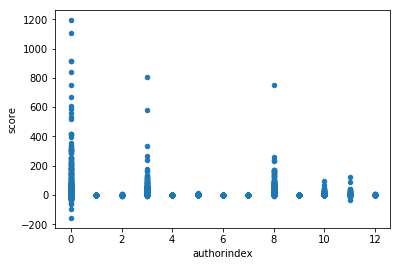

In [36]:
df.plot.scatter('authorindex', 'score')

Scores appear to cluster around zero, with what appear to be relationships between certain authors and high scoring comments.

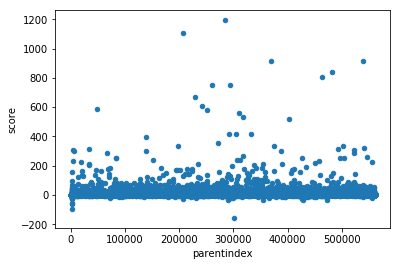

In [28]:
df.plot.scatter('parentindex', 'score')

Scores for parent indices appear to be randomly distributed and clustered around zero, with high scores appearing as potential outliers.

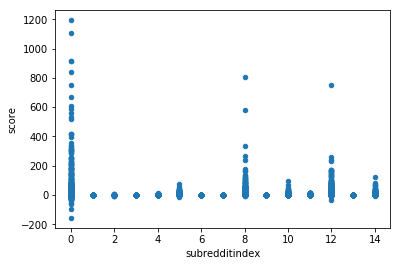

In [29]:
df.plot.scatter('subredditindex', 'score')

Scores based on subreddit seem to vary widely depending on the index, with indices 0, 8, and 12 appearing to have very high scores as well as large ranges.

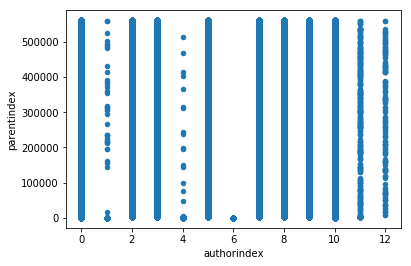

In [30]:
df.plot.scatter("authorindex", "parentindex")

The author at index 6 appears to only post to one parent thread, while the majority of the others seem evenly distributed. 4 and 1 also appear sparser. 

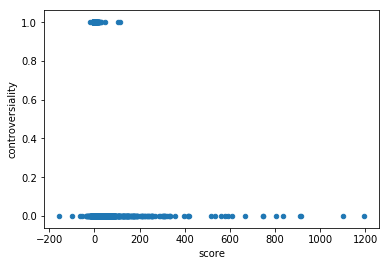

In [31]:
df.plot.scatter("score", "controversiality")

Controversial comments appear to have lower scores, but still a range of scores between a little less than 0 and 200.

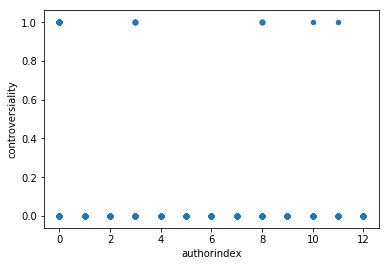

In [32]:
df.plot.scatter("authorindex", "controversiality")

It appears that less than half of the authors have comments that are controversial, but the distribution of comments for these authors is unclear.

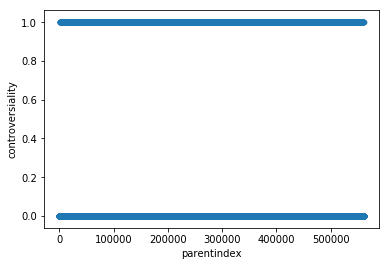

In [33]:
df.plot.scatter("parentindex", "controversiality")

There appears to be no relationship between the parent index of a comment and whether it is controversial or not.

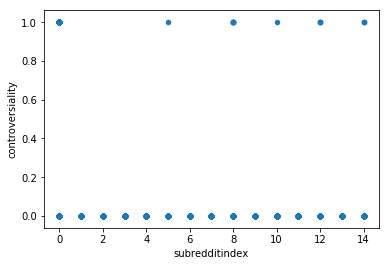

In [34]:
df.plot.scatter("subredditindex", "controversiality")

While 5 of the 15 subreddits appear to have both controversial and non-controversial posts--while the others only have non-controversial--the distribution between controversial and non-controversial is unclear.

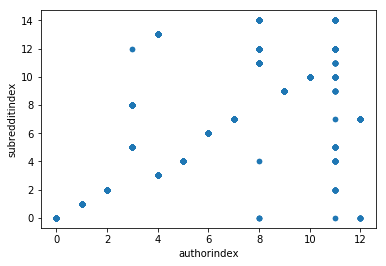

In [35]:
df.plot.scatter("authorindex", "subredditindex")

There does appear to be a relationship between author index and subreddit index. Although the author at index 11 does appear to have comments across all subreddits.

In [ ]:
spark.stop()